In [2]:
! git clone https://github.com/rpathak38/DL_Proj

Cloning into 'DL_Proj'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 86 (delta 40), reused 60 (delta 18), pack-reused 0
Receiving objects: 100% (86/86), 13.38 MiB | 44.07 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [2]:
cd DL_Proj

/root/GATech/cs7643/ami_proj/DL_Proj


In [3]:
%load_ext autoreload
%autoreload 1
import urllib.request
import tarfile
import numpy as np
import random
import os
import torch
from PIL import Image
from torchvision import transforms
import zipfile
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from unet import UNet
from tqdm import tqdm
from metrics_loss import dice_index, class_balanced_focal_ce_loss,calculate_iou,pixel_acc,dice_loss

In [4]:
seed_value = 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `torch` pseudo-random generator at a fixed value
torch.manual_seed(seed_value)

# 5. If you are using CUDA, set also the seed for it and enable deterministic behavior
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if using multi-GPU.
    # Below two lines ensure deterministic behavior, but may lead to slower training
    # due to the need to find algorithms that have deterministic behavior.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
# Check if CUDA is available
# Regardless of whether or not you are using GPU create the no gpu environment for now
is_cuda_available = torch.cuda.is_available()

# Print the status of CUDA availability
print("CUDA Available:", is_cuda_available)

# Set the device to CUDA if available, otherwise use CPU
device = torch.device("cuda" if is_cuda_available else "cpu")

# Print the device being used
print("Using device:", device)

CUDA Available: True
Using device: cuda


In [6]:
data_dir = "data"
aug_data_dir = "sbd_dat_mat"
large_dataset = False # set to false if you want small dataset (0k images vs 10k images)
download = True # specify true if you want to download data

In [7]:
# if download is True:
#     os.makedirs(data_dir, exist_ok=True)

#     voc_url = "http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar"
#     voc_name = "pascal_voc.tar"
#     voc_name = os.path.join(data_dir, voc_name)

#     urllib.request.urlretrieve(voc_url, voc_name)

#     with tarfile.open(voc_name) as tar:
#         tar.extractall(path=data_dir)

In [8]:
# # Augmentations dataset. This is a large dataset. Don't download unless you are planning on doing full training.
# if large_dataset is True:
#     aug_data_dir = "sbd_dat_mat"
#     os.makedirs(aug_data_dir, exist_ok=True)

#     aug_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/semantic_contours/benchmark.tgz"
#     aug_name = os.path.join(aug_data_dir, 'sbd_aug.tar')

#     # Downloading the file from the URL
#     urllib.request.urlretrieve(aug_url, aug_name)

#     with tarfile.open(aug_name) as tar:
#         tar.extractall(path=aug_data_dir)

In [9]:
from data_loader import pascalVOCLoader
from augmentations import *

# motivation for cropping instead of resizing: https://github.com/VainF/DeepLabV3Plus-Pytorch
img_size = 256 # pass in your image size
resize = "resize" # choose resizing method, "random_crop" which takes a random crop from the image, or use "resize" which scales the image down
# random crop preserves pixel level info while losing the whole picture, while resize keeps the whole picture, but may distort pixel level info

if resize == "random_crop":
    aug_list = Compose([RandomCrop(img_size)])
    img_size = "same"
else:
    aug_list = Compose([])

pascal_original = os.path.join(data_dir, "VOCdevkit/VOC2012")
if large_dataset is True:
    pascal_augment = os.path.join(aug_data_dir, "benchmark_RELEASE")
    split_train = "train_aug"
    split_val = "train_aug_val"
else:
    pascal_augment = None
    split_train = "train"
    split_val = "val"
train_dataset = pascalVOCLoader(pascal_original, pascal_augment, split=split_train, is_transform=True, img_size=img_size, augmentations=aug_list)
val_dataset = pascalVOCLoader(pascal_original, pascal_augment, split=split_val, is_transform=True, img_size=img_size, augmentations=aug_list)
# After this cell runs, switch to gpu environment if desired. Comment out dataset download code before running (above two cells).

Using small dataset (Pascal VOC)
Using small dataset (Pascal VOC)


In [10]:
freq = torch.zeros(len(train_dataset.get_pascal_labels()))
total = torch.zeros(1)
for img, mask in train_dataset:
    indices, counts = mask.unique(return_counts=True)
    for index, count in zip(indices, counts):
        freq[index] += count
    total += sum(counts)
freq = freq / total
print(freq)

tensor([0.7490, 0.0070, 0.0028, 0.0082, 0.0059, 0.0058, 0.0169, 0.0136, 0.0256,
        0.0110, 0.0080, 0.0124, 0.0161, 0.0089, 0.0108, 0.0457, 0.0062, 0.0085,
        0.0138, 0.0152, 0.0086])


In [11]:
class_weights = 1/freq
print(class_weights)

tensor([  1.3350, 142.0824, 354.8448, 121.6011, 170.6002, 173.5987,  59.1748,
         73.4235,  39.0592,  91.2982, 124.5666,  80.3877,  62.1089, 112.9127,
         92.2138,  21.8766, 161.7523, 118.2453,  72.5260,  65.9312, 116.1235])


In [12]:
from torch.utils.data import DataLoader

# DataLoader parameters
batch_size = 8  # You can adjust this depending on your GPU memory
shuffle = True   # Shuffles the dataset at every epoch
num_workers = 4  # Number of worker threads for loading data

# Create the DataLoaders for our training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [13]:
vis_length = 5
imgs = []
masks = []
for img, mask in train_loader:
    imgs.append(train_dataset.unnormalize(img[0]))
    print(mask[0].unique())
    print(mask[0].shape)
    mask_decoded = train_dataset.decode_segmap(mask[0].numpy())
    masks.append(torch.tensor(mask_decoded).permute(2, 0, 1))
    if len(imgs) == vis_length:
        break
print(imgs[0].shape)
print(masks[0].shape)

tensor([ 0, 19])
torch.Size([256, 256])
tensor([ 0, 12, 15, 17])
torch.Size([256, 256])
tensor([0, 1])
torch.Size([256, 256])
tensor([ 0,  7, 15])
torch.Size([256, 256])
tensor([ 0, 13])
torch.Size([256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


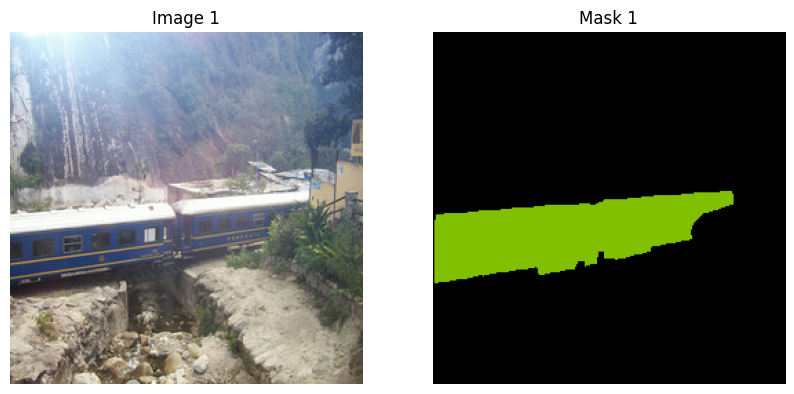

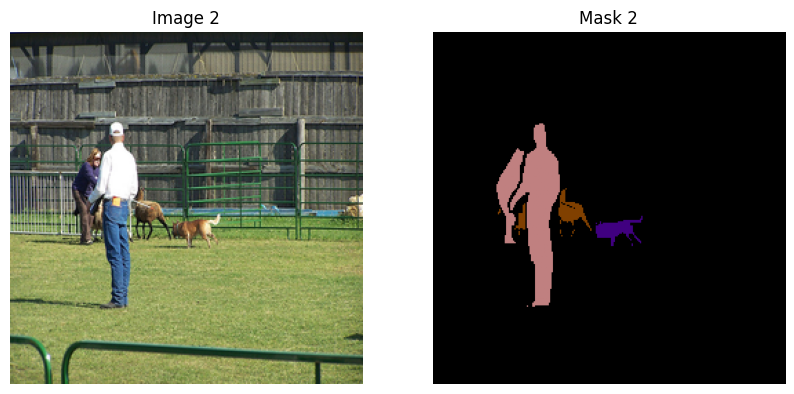

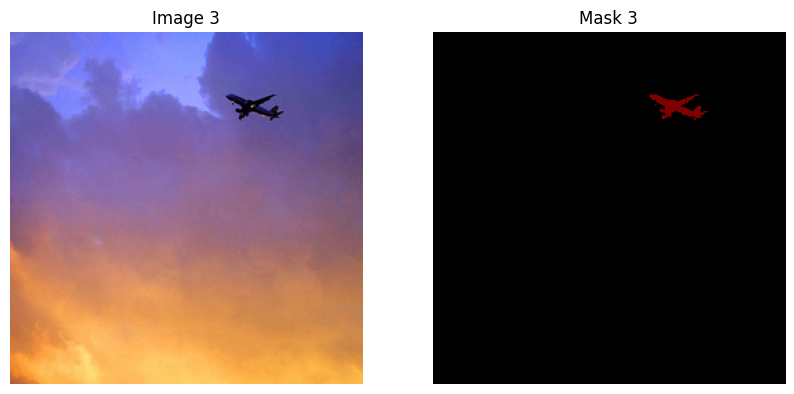

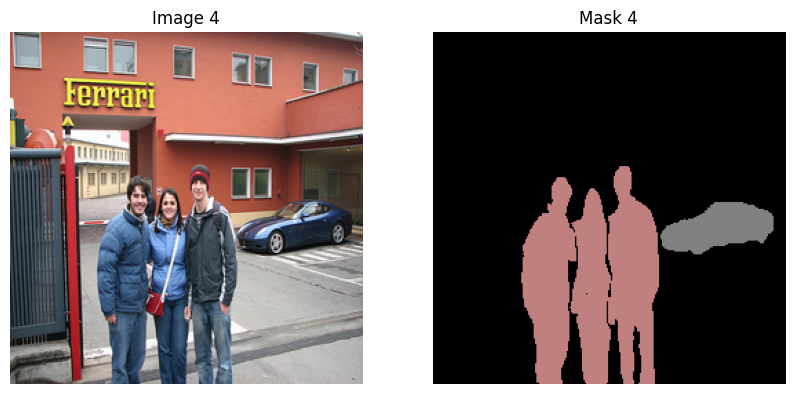

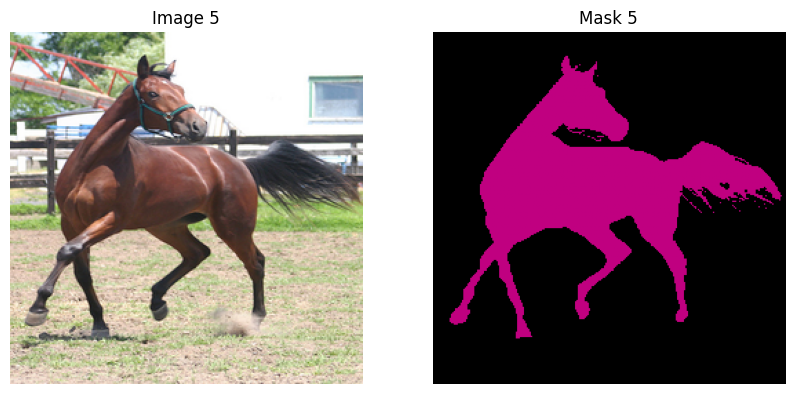

In [14]:
def visualize_image_and_mask_tensors(image_tensors, mask_tensors):
    """
    Visualize lists of image tensors and their corresponding mask tensors as regular images.

    Parameters:
        image_tensors (list of torch.Tensor): The list of image tensors to visualize.
        mask_tensors (list of torch.Tensor): The list of mask tensors to visualize.
    """
    for i, (image_tensor, mask_tensor) in enumerate(zip(image_tensors, mask_tensors)):
        # Convert the image tensor to numpy and change to HWC format for visualization
        image_np = image_tensor.permute(1, 2, 0).numpy()

        # Convert the mask tensor to numpy and change to HWC format for visualization
        mask_np = mask_tensor.permute(1, 2, 0).numpy()

        # Display the image and the mask side by side
        plt.figure(figsize=(10, 5))

        # Display the image
        plt.subplot(1, 2, 1)
        plt.imshow(image_np)
        plt.title(f'Image {i+1}')
        plt.axis('off')

        # Display the mask
        plt.subplot(1, 2, 2)
        plt.imshow(mask_np)
        plt.title(f'Mask {i+1}')
        plt.axis('off')

        plt.show()

# For testing, let's use the same image tensors and mask tensors as regular three-channel images
# We'll use the previously defined image_tensors and create new mask_tensors with 3 channels
mask_tensors = [torch.rand(3, 100, 100), torch.rand(3, 100, 100)]

# Test the function
visualize_image_and_mask_tensors(imgs, masks)

In [15]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def init_weights(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight)

# Initialize the model
model = UNet(3, 21, [64, 128, 256, 512])

# Move the model to the CUDA device if available
model = model.to(device)
class_weights = 1/freq
class_weights = class_weights.to(device)

epochs = 30
lr = 0.01
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

Using device: cuda


In [16]:
# Training and validation code
for epoch in range(epochs):
    print(f"EPOCH {epoch}:")
    model.train()
    batch_loss = batch_acc = batch_iou=batch_pacc=0.0

    for img, mask in tqdm(train_loader, desc=f"Training Loop, Epoch: {epoch}"):
        # Move data to CUDA
        img, mask = img.to(device), mask.to(device)
        optimizer.zero_grad()
        outs = model(img)
        loss = class_balanced_focal_ce_loss(outs, mask, weights=class_weights, gamma=2)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            outs=torch.argmax(outs,dim=1)
            accuracy = dice_index(outs, mask)
            iou=calculate_iou(outs,mask)
            pacc=pixel_acc(outs,mask)
            batch_loss += loss.item()
            batch_acc += accuracy.item()
            batch_iou+=iou
            batch_pacc+=pacc

    batch_loss /= len(train_loader)
    batch_acc /= len(train_loader)
    batch_iou/=len(train_loader)
    batch_pacc/=len(train_loader)
    print(f"Training loss: {batch_loss}, Training accuracy: {batch_pacc}, DICE:{batch_acc} ,IOU: {batch_iou}")
    model.eval()
    val_loss = val_acc = val_iou=val_pacc=0.0

    with torch.no_grad():
        for img, mask in tqdm(val_loader, desc=f"Validation Loop, Epoch: {epoch}"):
            # Move data to CUDA
            img, mask = img.to(device), mask.to(device)

            outs = model(img)
            loss = class_balanced_focal_ce_loss(outs, mask, weights=class_weights, gamma=2)
            outs=torch.argmax(outs,dim=1)
            iou=calculate_iou(outs,mask)
            pacc=pixel_acc(outs,mask)
            accuracy = dice_index(outs, mask)
            val_loss += loss.item()
            val_acc += accuracy.item()
            val_iou+=iou
            val_pacc+=pacc

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    val_iou/=len(val_loader)
    val_pacc/=len(val_loader)
    print(f"Validation loss: {val_loss}, Validation accuracy: {val_pacc},DICE:{val_acc},IOU: {val_iou}")

EPOCH 0:


Training Loop, Epoch: 0: 100%|██████████| 183/183 [00:55<00:00,  3.27it/s]


Training loss: 57.19263867862889, Training accuracy: 0.18100745975971222, DICE:0.5155048022667567 ,IOU: 0.25775240113337833


Validation Loop, Epoch: 0: 100%|██████████| 182/182 [00:18<00:00,  9.80it/s]


Validation loss: 58.10588587247408, Validation accuracy: 0.26236221194267273,DICE:0.5425430906342936,IOU: 0.2712715453171468
EPOCH 1:


Training Loop, Epoch: 1:  37%|███▋      | 68/183 [00:20<00:34,  3.30it/s]


KeyboardInterrupt: 

In [ ]:
# Check for CUDA availability
from unet_skip import UNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def init_weights(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight)

# Initialize the model
model = UNet(3, 21, [64, 128, 256, 512,1024])

# Move the model to the CUDA device if available
model = model.to(device)
class_weights = 1/freq
class_weights = class_weights.to(device)

epochs = 100
lr = 0.001
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
# Training and validation code
for epoch in range(epochs):
    print(f"EPOCH {epoch}:")
    model.train()
    batch_loss = batch_acc = batch_iou=batch_pacc=0.0

    for img, mask in tqdm(train_loader, desc=f"Training Loop, Epoch: {epoch}"):
        # Move data to CUDA
        img, mask = img.to(device), mask.to(device)
        optimizer.zero_grad()
        outs = model(img)
        # loss = class_balanced_focal_ce_loss(outs, mask, weights=class_weights, gamma=2)
        loss=dice_loss(outs, mask)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            outs=torch.argmax(outs,dim=1)
            accuracy = dice_index(outs, mask)
            iou=calculate_iou(outs,mask)
            pacc=pixel_acc(outs,mask)
            batch_loss += loss.item()
            batch_acc += accuracy.item()
            batch_iou+=iou
            batch_pacc+=pacc

    batch_loss /= len(train_loader)
    batch_acc /= len(train_loader)
    batch_iou/=len(train_loader)
    batch_pacc/=len(train_loader)
    print(f"Training loss: {batch_loss}, Training accuracy: {batch_pacc}, DICE:{batch_acc} ,IOU: {batch_iou}")
    model.eval()
    val_loss = val_acc = val_iou=val_pacc=0.0

    with torch.no_grad():
        for img, mask in tqdm(val_loader, desc=f"Validation Loop, Epoch: {epoch}"):
            # Move data to CUDA
            img, mask = img.to(device), mask.to(device)

            outs = model(img)
            loss = class_balanced_focal_ce_loss(outs, mask, weights=class_weights, gamma=2)
            outs=torch.argmax(outs,dim=1)
            iou=calculate_iou(outs,mask)
            pacc=pixel_acc(outs,mask)
            accuracy = dice_index(outs, mask)
            val_loss += loss.item()
            val_acc += accuracy.item()
            val_iou+=iou
            val_pacc+=pacc

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    val_iou/=len(val_loader)
    val_pacc/=len(val_loader)
    print(f"Validation loss: {val_loss}, Validation accuracy: {val_pacc},DICE:{val_acc},IOU: {val_iou}")

Using device: cuda
EPOCH 0:


Training Loop, Epoch: 0: 100%|██████████| 183/183 [01:09<00:00,  2.63it/s]


Training loss: 0.9904184572683657, Training accuracy: 0.35382071137428284, DICE:0.5963868200778961 ,IOU: 0.29819341003894806


Validation Loop, Epoch: 0: 100%|██████████| 182/182 [00:22<00:00,  8.02it/s]


Validation loss: 57.24687253511869, Validation accuracy: 0.4678754508495331,DICE:0.6578898944042542,IOU: 0.3289449472021271
EPOCH 1:


Training Loop, Epoch: 1: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9896014388141736, Training accuracy: 0.4403718113899231, DICE:0.6823820010886166 ,IOU: 0.3411910005443083


Validation Loop, Epoch: 1: 100%|██████████| 182/182 [00:22<00:00,  8.00it/s]


Validation loss: 55.80600127545032, Validation accuracy: 0.37215080857276917,DICE:0.6654282010846085,IOU: 0.33271410054230427
EPOCH 2:


Training Loop, Epoch: 2: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9890421371642357, Training accuracy: 0.47237423062324524, DICE:0.7059361609767695 ,IOU: 0.35296808048838474


Validation Loop, Epoch: 2: 100%|██████████| 182/182 [00:22<00:00,  8.00it/s]


Validation loss: 55.61118852175199, Validation accuracy: 0.5189074873924255,DICE:0.749456966643805,IOU: 0.3747284833219025
EPOCH 3:


Training Loop, Epoch: 3: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9885889285249136, Training accuracy: 0.5121939778327942, DICE:0.7402414892866311 ,IOU: 0.37012074464331557


Validation Loop, Epoch: 3: 100%|██████████| 182/182 [00:23<00:00,  7.64it/s]


Validation loss: 55.3356600017338, Validation accuracy: 0.5182841420173645,DICE:0.7751772443016807,IOU: 0.38758862215084033
EPOCH 4:


Training Loop, Epoch: 4: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9881468688855406, Training accuracy: 0.5296527147293091, DICE:0.7561988925021854 ,IOU: 0.3780994462510927


Validation Loop, Epoch: 4: 100%|██████████| 182/182 [00:22<00:00,  7.99it/s]


Validation loss: 54.55337965619433, Validation accuracy: 0.4685727059841156,DICE:0.7411077574386702,IOU: 0.3705538787193351
EPOCH 5:


Training Loop, Epoch: 5: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9877741626703023, Training accuracy: 0.5347521901130676, DICE:0.7585701017431874 ,IOU: 0.3792850508715937


Validation Loop, Epoch: 5: 100%|██████████| 182/182 [00:22<00:00,  7.98it/s]


Validation loss: 54.394168130644076, Validation accuracy: 0.5329390168190002,DICE:0.787873095699719,IOU: 0.3939365478498595
EPOCH 6:


Training Loop, Epoch: 6: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9874101750186233, Training accuracy: 0.5515892505645752, DICE:0.7782898279812818 ,IOU: 0.3891449139906409


Validation Loop, Epoch: 6: 100%|██████████| 182/182 [00:22<00:00,  7.99it/s]


Validation loss: 54.275674453148476, Validation accuracy: 0.5128880143165588,DICE:0.7598286935916314,IOU: 0.3799143467958157
EPOCH 7:


Training Loop, Epoch: 7: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9870928766948929, Training accuracy: 0.5529337525367737, DICE:0.7763126078850585 ,IOU: 0.38815630394252926


Validation Loop, Epoch: 7: 100%|██████████| 182/182 [00:22<00:00,  7.98it/s]


Validation loss: 53.777197219513276, Validation accuracy: 0.5057258605957031,DICE:0.7664089292942823,IOU: 0.38320446464714114
EPOCH 8:


Training Loop, Epoch: 8: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9868117769559225, Training accuracy: 0.5621528029441833, DICE:0.7963004392352911 ,IOU: 0.3981502196176456


Validation Loop, Epoch: 8: 100%|██████████| 182/182 [00:22<00:00,  7.98it/s]


Validation loss: 53.67820751274025, Validation accuracy: 0.5211369395256042,DICE:0.7704170503459133,IOU: 0.3852085251729567
EPOCH 9:


Training Loop, Epoch: 9: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.986527355967975, Training accuracy: 0.5673168301582336, DICE:0.8013181043127195 ,IOU: 0.4006590521563598


Validation Loop, Epoch: 9: 100%|██████████| 182/182 [00:22<00:00,  7.98it/s]


Validation loss: 54.935997218876096, Validation accuracy: 0.5750133395195007,DICE:0.7850012861110351,IOU: 0.3925006430555176
EPOCH 10:


Training Loop, Epoch: 10: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9863231338438441, Training accuracy: 0.5720179080963135, DICE:0.8032357596634515 ,IOU: 0.40161787983172575


Validation Loop, Epoch: 10: 100%|██████████| 182/182 [00:22<00:00,  7.98it/s]


Validation loss: 53.0904164995466, Validation accuracy: 0.5339637994766235,DICE:0.8090235345311217,IOU: 0.4045117672655609
EPOCH 11:


Training Loop, Epoch: 11: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9861197878754204, Training accuracy: 0.5722751021385193, DICE:0.8049186065874464 ,IOU: 0.4024593032937232


Validation Loop, Epoch: 11: 100%|██████████| 182/182 [00:22<00:00,  7.98it/s]


Validation loss: 53.04365436847393, Validation accuracy: 0.525087296962738,DICE:0.7849615492991039,IOU: 0.39248077464955194
EPOCH 12:


Training Loop, Epoch: 12: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9859332018862657, Training accuracy: 0.5779324769973755, DICE:0.816507031031645 ,IOU: 0.4082535155158225


Validation Loop, Epoch: 12: 100%|██████████| 182/182 [00:22<00:00,  7.98it/s]


Validation loss: 53.142375872685356, Validation accuracy: 0.5561395883560181,DICE:0.8222880415864043,IOU: 0.41114402079320217
EPOCH 13:


Training Loop, Epoch: 13: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9857430109560815, Training accuracy: 0.588049590587616, DICE:0.8289304750213207 ,IOU: 0.41446523751066033


Validation Loop, Epoch: 13: 100%|██████████| 182/182 [00:22<00:00,  7.98it/s]


Validation loss: 53.30584446414486, Validation accuracy: 0.591675877571106,DICE:0.8528955523129348,IOU: 0.4264477761564674
EPOCH 14:


Training Loop, Epoch: 14: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9855761775553552, Training accuracy: 0.594106912612915, DICE:0.831790041076681 ,IOU: 0.4158950205383405


Validation Loop, Epoch: 14: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 53.35042757516379, Validation accuracy: 0.557413637638092,DICE:0.8053660875820852,IOU: 0.4026830437910426
EPOCH 15:


Training Loop, Epoch: 15: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.985418563657771, Training accuracy: 0.597470223903656, DICE:0.8373618515137115 ,IOU: 0.4186809257568557


Validation Loop, Epoch: 15: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 53.12057585244651, Validation accuracy: 0.5872516632080078,DICE:0.851154183948433,IOU: 0.4255770919742165
EPOCH 16:


Training Loop, Epoch: 16: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9852802417968791, Training accuracy: 0.5999376177787781, DICE:0.8412850723891961 ,IOU: 0.42064253619459807


Validation Loop, Epoch: 16: 100%|██████████| 182/182 [00:22<00:00,  7.98it/s]


Validation loss: 52.44446011427995, Validation accuracy: 0.5883849859237671,DICE:0.8272875752095338,IOU: 0.4136437876047669
EPOCH 17:


Training Loop, Epoch: 17: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9851816785140116, Training accuracy: 0.6071411371231079, DICE:0.8556051708635737 ,IOU: 0.42780258543178684


Validation Loop, Epoch: 17: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 52.87567744412265, Validation accuracy: 0.6420931220054626,DICE:0.850993289397313,IOU: 0.4254966446986565
EPOCH 18:


Training Loop, Epoch: 18: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9850946283731304, Training accuracy: 0.6108892560005188, DICE:0.8527390536714773 ,IOU: 0.42636952683573864


Validation Loop, Epoch: 18: 100%|██████████| 182/182 [00:22<00:00,  7.98it/s]


Validation loss: 52.62022110656068, Validation accuracy: 0.6276829242706299,DICE:0.8893331272916479,IOU: 0.44466656364582396
EPOCH 19:


Training Loop, Epoch: 19: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9849370936226975, Training accuracy: 0.6188316941261292, DICE:0.8679656290291436 ,IOU: 0.4339828145145718


Validation Loop, Epoch: 19: 100%|██████████| 182/182 [00:22<00:00,  7.98it/s]


Validation loss: 52.41017452701107, Validation accuracy: 0.6123470664024353,DICE:0.8634272175175803,IOU: 0.43171360875879017
EPOCH 20:


Training Loop, Epoch: 20: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9848394152896652, Training accuracy: 0.6221598386764526, DICE:0.8624258370347362 ,IOU: 0.4312129185173681


Validation Loop, Epoch: 20: 100%|██████████| 182/182 [00:22<00:00,  7.98it/s]


Validation loss: 52.34065290597769, Validation accuracy: 0.604377031326294,DICE:0.8662208184436128,IOU: 0.4331104092218064
EPOCH 21:


Training Loop, Epoch: 21: 100%|██████████| 183/183 [01:08<00:00,  2.67it/s]


Training loss: 0.9846877774905637, Training accuracy: 0.6269592642784119, DICE:0.8749443974976983 ,IOU: 0.43747219874884913


Validation Loop, Epoch: 21: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 51.832100973024474, Validation accuracy: 0.6477314233779907,DICE:0.9082724067208531,IOU: 0.45413620336042654
EPOCH 22:


Training Loop, Epoch: 22: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9846400488269785, Training accuracy: 0.6254015564918518, DICE:0.8710826835671409 ,IOU: 0.43554134178357046


Validation Loop, Epoch: 22: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 52.122769670172055, Validation accuracy: 0.653536319732666,DICE:0.8902638808384047,IOU: 0.44513194041920234
EPOCH 23:


Training Loop, Epoch: 23: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9845618204992326, Training accuracy: 0.6253366470336914, DICE:0.8791748952995884 ,IOU: 0.4395874476497942


Validation Loop, Epoch: 23: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 51.81733365111299, Validation accuracy: 0.5919269919395447,DICE:0.8610401189589239,IOU: 0.4305200594794619
EPOCH 24:


Training Loop, Epoch: 24: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.98442487801359, Training accuracy: 0.6363634467124939, DICE:0.8921689469306195 ,IOU: 0.44608447346530977


Validation Loop, Epoch: 24: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 51.81004448775407, Validation accuracy: 0.6159111857414246,DICE:0.8897294004212369,IOU: 0.44486470021061847
EPOCH 25:


Training Loop, Epoch: 25: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9843760741864397, Training accuracy: 0.6388353705406189, DICE:0.8913035832467626 ,IOU: 0.4456517916233813


Validation Loop, Epoch: 25: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 51.58635971572373, Validation accuracy: 0.6283721327781677,DICE:0.9042358138076552,IOU: 0.4521179069038276
EPOCH 26:


Training Loop, Epoch: 26: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9842608512425032, Training accuracy: 0.6454474329948425, DICE:0.9102572186397073 ,IOU: 0.45512860931985366


Validation Loop, Epoch: 26: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 51.83799553965474, Validation accuracy: 0.637677788734436,DICE:0.9176777553754848,IOU: 0.4588388776877424
EPOCH 27:


Training Loop, Epoch: 27: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9841884664499043, Training accuracy: 0.6499114036560059, DICE:0.9052552102042026 ,IOU: 0.4526276051021013


Validation Loop, Epoch: 27: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 50.53763077285264, Validation accuracy: 0.6148079633712769,DICE:0.9018204845897444,IOU: 0.4509102422948722
EPOCH 28:


Training Loop, Epoch: 28: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9841132502738243, Training accuracy: 0.6513316035270691, DICE:0.9162972077645891 ,IOU: 0.45814860388229456


Validation Loop, Epoch: 28: 100%|██████████| 182/182 [00:22<00:00,  7.98it/s]


Validation loss: 51.708744651668674, Validation accuracy: 0.6499043107032776,DICE:0.930461157972996,IOU: 0.465230578986498
EPOCH 29:


Training Loop, Epoch: 29: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9840452667793941, Training accuracy: 0.6533748507499695, DICE:0.9187146005083303 ,IOU: 0.45935730025416516


Validation Loop, Epoch: 29: 100%|██████████| 182/182 [00:22<00:00,  7.98it/s]


Validation loss: 51.214533847766916, Validation accuracy: 0.6372841000556946,DICE:0.916896212886978,IOU: 0.458448106443489
EPOCH 30:


Training Loop, Epoch: 30: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9839200250438003, Training accuracy: 0.6581226587295532, DICE:0.9178177789260781 ,IOU: 0.45890888946303904


Validation Loop, Epoch: 30: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 51.533882560310786, Validation accuracy: 0.6987998485565186,DICE:0.938048052755031,IOU: 0.4690240263775155
EPOCH 31:


Training Loop, Epoch: 31: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9839232055867304, Training accuracy: 0.6538794636726379, DICE:0.9003442354866715 ,IOU: 0.45017211774333576


Validation Loop, Epoch: 31: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 51.45061548463591, Validation accuracy: 0.6452363729476929,DICE:0.9158019587233827,IOU: 0.45790097936169133
EPOCH 32:


Training Loop, Epoch: 32: 100%|██████████| 183/183 [01:08<00:00,  2.67it/s]


Training loss: 0.9838291198178067, Training accuracy: 0.6597962379455566, DICE:0.9277437269036236 ,IOU: 0.4638718634518118


Validation Loop, Epoch: 32: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 51.189352025042524, Validation accuracy: 0.6915886402130127,DICE:0.9540260293326535,IOU: 0.47701301466632673
EPOCH 33:


Training Loop, Epoch: 33: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9837348027958897, Training accuracy: 0.6623653173446655, DICE:0.92946500074668 ,IOU: 0.46473250037334


Validation Loop, Epoch: 33: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 51.02868676971603, Validation accuracy: 0.6323300004005432,DICE:0.9127537021925162,IOU: 0.4563768510962581
EPOCH 34:


Training Loop, Epoch: 34: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9836528806087098, Training accuracy: 0.6706198453903198, DICE:0.9464592699144707 ,IOU: 0.47322963495723536


Validation Loop, Epoch: 34: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 50.320428806346854, Validation accuracy: 0.6732800006866455,DICE:0.966470656486658,IOU: 0.483235328243329
EPOCH 35:


Training Loop, Epoch: 35: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9836121533737808, Training accuracy: 0.6715113520622253, DICE:0.94737717134705 ,IOU: 0.473688585673525


Validation Loop, Epoch: 35: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 50.954177468687625, Validation accuracy: 0.6473300457000732,DICE:0.9299642283182877,IOU: 0.46498211415914387
EPOCH 36:


Training Loop, Epoch: 36: 100%|██████████| 183/183 [01:08<00:00,  2.67it/s]


Training loss: 0.9835823852507795, Training accuracy: 0.6712554097175598, DICE:0.9414095766231662 ,IOU: 0.4707047883115831


Validation Loop, Epoch: 36: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 51.46505945855444, Validation accuracy: 0.6326512098312378,DICE:0.9142396964214661,IOU: 0.45711984821073304
EPOCH 37:


Training Loop, Epoch: 37: 100%|██████████| 183/183 [01:08<00:00,  2.67it/s]


Training loss: 0.9835394109533133, Training accuracy: 0.6715922355651855, DICE:0.9470155066479751 ,IOU: 0.47350775332398753


Validation Loop, Epoch: 37: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 50.456141587142106, Validation accuracy: 0.6362689137458801,DICE:0.930479808986842,IOU: 0.465239904493421
EPOCH 38:


Training Loop, Epoch: 38: 100%|██████████| 183/183 [01:08<00:00,  2.67it/s]


Training loss: 0.9834134109684678, Training accuracy: 0.676647424697876, DICE:0.9468774688048441 ,IOU: 0.47343873440242207


Validation Loop, Epoch: 38: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 50.775983338827615, Validation accuracy: 0.6531205177307129,DICE:0.9364240164612676,IOU: 0.4682120082306338
EPOCH 39:


Training Loop, Epoch: 39: 100%|██████████| 183/183 [01:08<00:00,  2.67it/s]


Training loss: 0.983333331313941, Training accuracy: 0.6788341999053955, DICE:0.9570330570304328 ,IOU: 0.4785165285152164


Validation Loop, Epoch: 39: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 50.59835245321085, Validation accuracy: 0.6541463732719421,DICE:0.9498225732164068,IOU: 0.4749112866082034
EPOCH 40:


Training Loop, Epoch: 40: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9833297097617811, Training accuracy: 0.6788731217384338, DICE:0.9544789230888658 ,IOU: 0.4772394615444329


Validation Loop, Epoch: 40: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 50.95577373085441, Validation accuracy: 0.6698598265647888,DICE:0.9614781570303571,IOU: 0.48073907851517855
EPOCH 41:


Training Loop, Epoch: 41: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9831975959037822, Training accuracy: 0.6875028014183044, DICE:0.9757971108936873 ,IOU: 0.48789855544684363


Validation Loop, Epoch: 41: 100%|██████████| 182/182 [00:22<00:00,  7.96it/s]


Validation loss: 50.12870491991986, Validation accuracy: 0.6913631558418274,DICE:0.9782906069860353,IOU: 0.48914530349301766
EPOCH 42:


Training Loop, Epoch: 42: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.983135406436816, Training accuracy: 0.6868416666984558, DICE:0.9784243325066697 ,IOU: 0.48921216625333486


Validation Loop, Epoch: 42: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 50.15252754714463, Validation accuracy: 0.67477947473526,DICE:0.95593234536412,IOU: 0.47796617268206
EPOCH 43:


Training Loop, Epoch: 43: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9830252088484217, Training accuracy: 0.6945456862449646, DICE:0.9873639993328865 ,IOU: 0.49368199966644327


Validation Loop, Epoch: 43: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 50.50793277300321, Validation accuracy: 0.6770036816596985,DICE:0.9822678091106835,IOU: 0.4911339045553417
EPOCH 44:


Training Loop, Epoch: 44: 100%|██████████| 183/183 [01:08<00:00,  2.67it/s]


Training loss: 0.9829169361969161, Training accuracy: 0.6992807388305664, DICE:0.9959865039815017 ,IOU: 0.49799325199075084


Validation Loop, Epoch: 44: 100%|██████████| 182/182 [00:22<00:00,  7.96it/s]


Validation loss: 50.28275107289409, Validation accuracy: 0.6905420422554016,DICE:0.9755132096809346,IOU: 0.4877566048404673
EPOCH 45:


Training Loop, Epoch: 45: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9828957107549157, Training accuracy: 0.7012181282043457, DICE:0.9921823691149227 ,IOU: 0.4960911845574614


Validation Loop, Epoch: 45: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 50.012359682020254, Validation accuracy: 0.689075767993927,DICE:0.9762262760937869,IOU: 0.48811313804689344
EPOCH 46:


Training Loop, Epoch: 46: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9827792107081804, Training accuracy: 0.7063122391700745, DICE:1.0151364580203928 ,IOU: 0.5075682290101964


Validation Loop, Epoch: 46: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 50.19931628677871, Validation accuracy: 0.6704670786857605,DICE:0.9636404949885148,IOU: 0.4818202474942574
EPOCH 47:


Training Loop, Epoch: 47: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9826866398092176, Training accuracy: 0.7121813893318176, DICE:1.0210848973422755 ,IOU: 0.5105424486711377


Validation Loop, Epoch: 47: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 50.17711144751245, Validation accuracy: 0.6810656189918518,DICE:0.969553373344652,IOU: 0.484776686672326
EPOCH 48:


Training Loop, Epoch: 48: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9826447589149891, Training accuracy: 0.7132425308227539, DICE:1.0264327819230126 ,IOU: 0.5132163909615063


Validation Loop, Epoch: 48: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 50.19696965060391, Validation accuracy: 0.6742718815803528,DICE:0.9665316765779978,IOU: 0.4832658382889989
EPOCH 49:


Training Loop, Epoch: 49: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9825707875965722, Training accuracy: 0.719230592250824, DICE:1.040180707889828 ,IOU: 0.520090353944914


Validation Loop, Epoch: 49: 100%|██████████| 182/182 [00:22<00:00,  7.96it/s]


Validation loss: 49.81775742834741, Validation accuracy: 0.6826948523521423,DICE:0.9775885589175172,IOU: 0.4887942794587586
EPOCH 50:


Training Loop, Epoch: 50: 100%|██████████| 183/183 [01:08<00:00,  2.67it/s]


Training loss: 0.9824898816197296, Training accuracy: 0.7234930992126465, DICE:1.0480457707181003 ,IOU: 0.5240228853590502


Validation Loop, Epoch: 50: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 50.17769249716958, Validation accuracy: 0.6803961992263794,DICE:0.9756164992903615,IOU: 0.48780824964518077
EPOCH 51:


Training Loop, Epoch: 51: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9823167646517519, Training accuracy: 0.7326629161834717, DICE:1.06296663987832 ,IOU: 0.53148331993916


Validation Loop, Epoch: 51: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 50.26648534523262, Validation accuracy: 0.670503556728363,DICE:0.9524283138932762,IOU: 0.4762141569466381
EPOCH 52:


Training Loop, Epoch: 52: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9823279139774094, Training accuracy: 0.7332362532615662, DICE:1.0727744766923248 ,IOU: 0.5363872383461624


Validation Loop, Epoch: 52: 100%|██████████| 182/182 [00:22<00:00,  7.94it/s]


Validation loss: 50.69644471053239, Validation accuracy: 0.698907196521759,DICE:0.985705208156135,IOU: 0.4928526040780675
EPOCH 53:


Training Loop, Epoch: 53: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9821925378236614, Training accuracy: 0.7406938076019287, DICE:1.0888544545799006 ,IOU: 0.5444272272899503


Validation Loop, Epoch: 53: 100%|██████████| 182/182 [00:22<00:00,  7.96it/s]


Validation loss: 49.64055811179863, Validation accuracy: 0.6812710762023926,DICE:0.978469519006027,IOU: 0.4892347595030135
EPOCH 54:


Training Loop, Epoch: 54: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9821240869376178, Training accuracy: 0.7460549473762512, DICE:1.1008201228464887 ,IOU: 0.5504100614232443


Validation Loop, Epoch: 54: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 50.15063856984233, Validation accuracy: 0.6734113097190857,DICE:0.959308982877941,IOU: 0.4796544914389705
EPOCH 55:


Training Loop, Epoch: 55: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9821310525383454, Training accuracy: 0.7458499073982239, DICE:1.1018787114346613 ,IOU: 0.5509393557173307


Validation Loop, Epoch: 55: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 50.66093195401705, Validation accuracy: 0.6850253343582153,DICE:0.9680645020453484,IOU: 0.4840322510226742
EPOCH 56:


Training Loop, Epoch: 56: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9820590364477022, Training accuracy: 0.7440847158432007, DICE:1.0986621418937308 ,IOU: 0.5493310709468654


Validation Loop, Epoch: 56: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 50.71157611595405, Validation accuracy: 0.6897602081298828,DICE:0.9728858909764133,IOU: 0.48644294548820666
EPOCH 57:


Training Loop, Epoch: 57: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9818812875799794, Training accuracy: 0.7606893181800842, DICE:1.1276706698162309 ,IOU: 0.5638353349081154


Validation Loop, Epoch: 57: 100%|██████████| 182/182 [00:22<00:00,  7.98it/s]


Validation loss: 51.6316833286495, Validation accuracy: 0.7248644232749939,DICE:0.9525687071791553,IOU: 0.47628435358957766
EPOCH 58:


Training Loop, Epoch: 58: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.981855971891372, Training accuracy: 0.7574707865715027, DICE:1.1258116550132877 ,IOU: 0.5629058275066439


Validation Loop, Epoch: 58: 100%|██████████| 182/182 [00:22<00:00,  7.98it/s]


Validation loss: 50.90884145799574, Validation accuracy: 0.6630011796951294,DICE:0.9489494447524731,IOU: 0.47447472237623656
EPOCH 59:


Training Loop, Epoch: 59: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Training loss: 0.9818075644513948, Training accuracy: 0.7682520151138306, DICE:1.159848767388714 ,IOU: 0.579924383694357


Validation Loop, Epoch: 59: 100%|██████████| 182/182 [00:22<00:00,  7.97it/s]


Validation loss: 50.537119813017796, Validation accuracy: 0.6818974614143372,DICE:0.9718842308272372,IOU: 0.4859421154136186
EPOCH 60:


Training Loop, Epoch: 60:  68%|██████▊   | 125/183 [00:46<00:21,  2.68it/s]

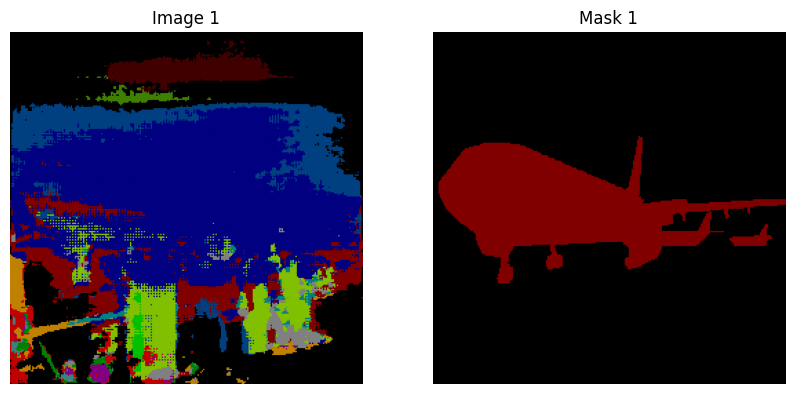

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


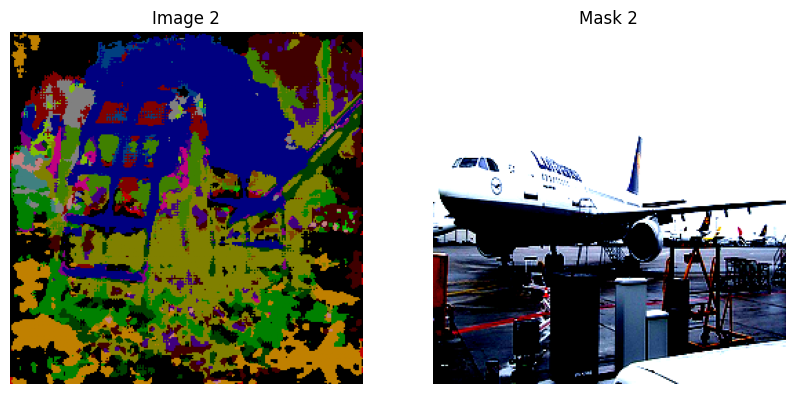

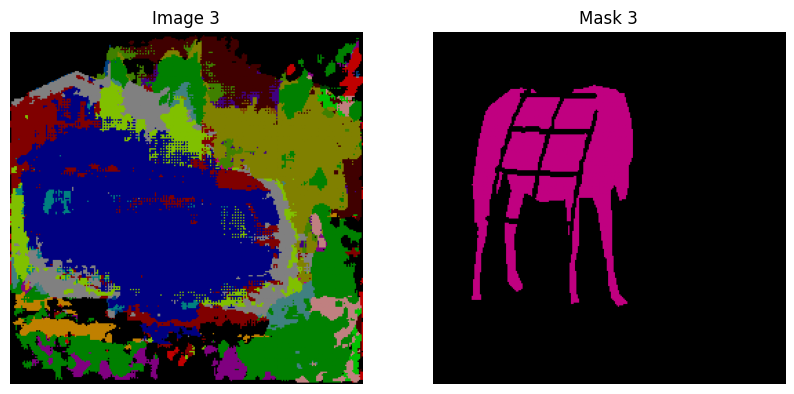

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


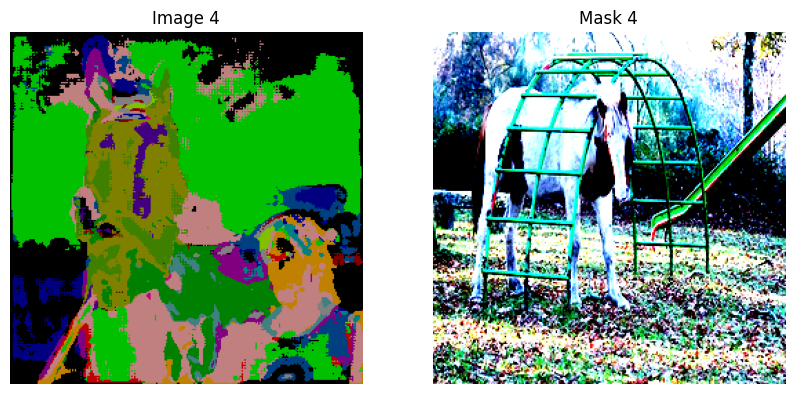

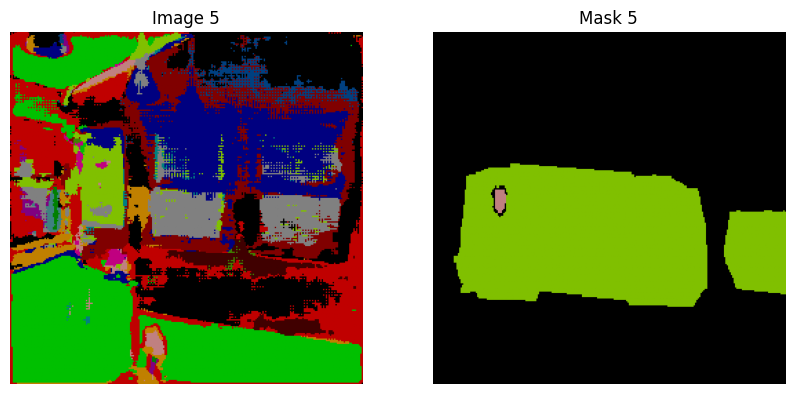

In [24]:
vis_length = 5
imgs = []
masks = []
model = model.to('cpu')
for index, (img, mask) in enumerate(val_loader):
    img = img[0].unsqueeze(0)
    mask = mask[0]
    outs = model(img)  # (NCHW)
    outs = torch.argmax(outs, dim=1)  # NHW
    outs = outs.squeeze(0)
    #print(index, torch.unique(outs, return_counts=True))
    #print(index, torch.unique(mask, return_counts=True))
    mask_decoded = val_dataset.decode_segmap(mask.numpy())
    masks.append(torch.tensor(mask_decoded).permute(2, 0, 1))
    #print(img.shape)
    masks.append(img.squeeze(0))
    outs_decoded = val_dataset.decode_segmap(outs.numpy())
    imgs.append(torch.tensor(outs_decoded).permute(2, 0, 1))
    if len(imgs) == 5:
        break
visualize_image_and_mask_tensors(imgs, masks)